# **##################### Problem 3 #####################**

In the following, you will load some data, i.e., simulation results from training a 500-neurons RNN to mimic target functions similar to calcium fluorescence signals collected from a population of active neurons in the prefrontal cortex of a mammalian nervous system. 

Your task is to analyze these data using the following a recipe, and plot the results.


As a first step, let's load and open the data. Please follow the instructions carefully.

1. Download the data file ('pset_p3.mat') from here:
https://drive.google.com/file/d/1imOA-ipWWrv-CXobZ2rMUiiUxN0Hsc8B/view?usp=sharing

2. Upload the dataset 'pset_p3.mat' to your personal Google Drive. Please just upload it to the top level, i.e. not within any folder.

3. Run the piece of code just below. 
The code connects to your Google Drive via this part here:
```
from google.colab import drive
drive.mount('/content/drive')
```
It will prompt you to open a new tab, sign in to your google account, and copy a password. You'll have to enter the password below the prompt. 

Note: if you correctly placed the file in the main folder of your Drive, you should not get any error. However, in case you get errors, you can try to look for the file manually: there's a Files button in the left column of this colab, where you can browse through your Google Drive. 


In [ ]:
### Import libraries

import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Some more definitions for plotting

colors = np.array([[0.1254902 , 0.29019608, 0.52941176],
       [0.80784314, 0.36078431, 0.        ],
       [0.30588235, 0.60392157, 0.02352941],
       [0.64313725, 0.        , 0.        ]])

figsize = (8, 3)

### Import data file

from google.colab import drive
drive.mount('/content/drive')

data_dir = "drive/MyDrive/pset_p3.mat"
try:
    import hdf5storage
except:
    !pip install hdf5storage
    import hdf5storage
p3_info = hdf5storage.loadmat(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you manage to correctly load the file, then the file contains:
* Data in a neurons x time matrix used as target functions to train the above; 
* Initial random and trained recurrent interaction matrices (both NxN sized).  
* Firing rates of the trained RNN in a neurons x time matrix; 
* firing rates of the same RNN before training in a neurons x time matrix.

Specifically, the content of the file is as follows:

 ```
N     # N neurons
g     # variance of the initial weights

# Network activity of untrained and trained network
t     # time vector 
R0    # Rates of untrained network  (N x time)
R     # Rates of trained network  (N x time)

# Target activitiy and corresponding times
target_t            # time vector for targets
target_activity     # targets

J0    # Initial random weight matrix (NxN)
J     # Trained weight matrix (NxN)
```

In the following piece of code, we extract those quantities from the file.


In [ ]:
#Load variables into name space

# Number of neurons, g
N = p3_info["N"]
g = p3_info["g"]
# Activity before and after training
t = p3_info["t"]
R0 = p3_info["R0"]
R = p3_info["R"]
# Training targets
target_t = p3_info["target_t"]
target_R = p3_info["target_activity"]
# Weight matrices
J0 = p3_info["J0"]
J = p3_info["J"]

# Join activity matrices
lbls = ["Before training", "After training", "Target"]
Rs = [R0, R, target_R]

## Dynamics

**a)** Plot the firing rate of 3 randomly selected units in the RNN super-imposed on their respective target functions. 


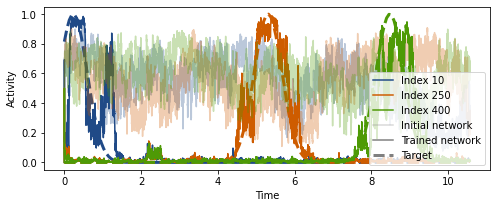

In [ ]:
# Plot 3 randomly selected units and their targets

idxs = np.array([10, 250, 400])
# idxs = np.random.choice(N, 3)

fig = plt.figure(figsize=figsize)
ax = fig.subplots(1, 1)

for i, idx in enumerate(idxs):
    ax.plot(t, R0[idx], c=colors[i], alpha=0.3)
    ax.plot(t, R[idx], c=colors[i], label="Index %d" % idx)
    ax.plot(target_t, target_R[idx], '--', lw=3, c=colors[i])

ax.plot(0, 0, '-', c='0.5', alpha=0.3, label="Initial network")
ax.plot(0, 0, '-', c='0.5', label="Trained network")
ax.plot(0, 0, '--', c='0.5', lw=3, label="Target")

ax.legend(loc=4)

ax.set_xlabel("Time")
ax.set_ylabel("Activity")

plt.show(fig)
plt.close(fig)

**Solution:** The target looks like a moving Gaussian bump, with higher neuron indices corresponding to later times. 

The trained activity tracks the target, even though in a noisy manner. 

For completeness, we visualize activity for all neurons in the target, initial and trained dataset.

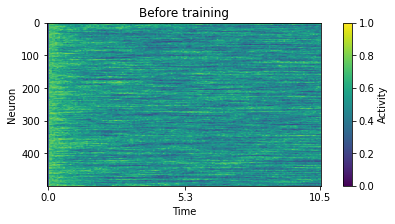

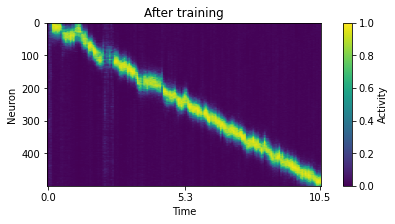

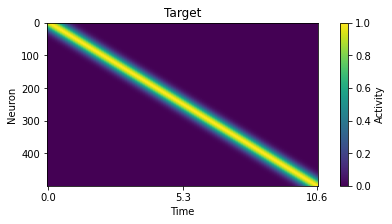

In [ ]:
# Plot activity for all neurons before/after training and target

# The target data has much less time steps. To simplify the plotting
# we will only show every `step`-th time point, so that 
# target and final activity have roughly the same shape.

step = R.shape[1] // target_R.shape[1]
steps = [step, step, 1]
ts = [t, t, target_t]

for i, (t_i, R_i) in enumerate(zip(ts, Rs)):

    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(1, 1)
    
    step = steps[i]
    im = ax.imshow(R_i[:, ::step], aspect=0.2, vmin=0, vmax=1)
    plt.colorbar(im, label="Activity")

    # Label x axis
    # So that the labels show the actual time.
    nt = len(t_i[::step])
    xticks = np.array([0, nt//2, nt-1])
    ax.set_xticks(xticks)
    ax.set_xticklabels(["%.1f" % tt for tt in t_i[::step][xticks]])

    ax.set_title(lbls[i])
    ax.set_xlabel("Time")
    ax.set_ylabel("Neuron")
    plt.show(fig)
    plt.close(fig)

**b)** You figured out how to do PCA in the first hands-on lab session. Can you generate the same state space diagram for the outputs of the trained network? Compared to the state space picture for the untrained RNN, how has training changed the picture? How about when compared to the “target data”?

**SOLUTION:** For each dataset (R_i in Rs), we create a pca object, run the fit, and project the dataset on the principal components.

In [ ]:
# Compute PCA for all three matrices

# Number of components to keep
n_comp = 50

# Results
pcas = []
R_projs = []
cevrs = []
time0 = time.time()
for R_i in Rs:
    pca_i = PCA(n_comp)
    pca_i.fit(R_i.T)
    pcas.append(pca_i)
    
    # Projections
    R_i_proj = pca_i.transform(R_i.T)
    R_projs.append(R_i_proj)

    # Cumulative explained variance ratio
    cum_evr = pca_i.explained_variance_ratio_.cumsum()
    cevrs.append(cum_evr)

print("Computing PCA took %.1f sec." % (time.time() - time0))

Computing PCA took 1.8 sec.


We now plot projections of activity of PCs.

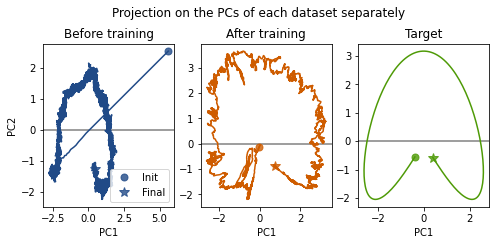

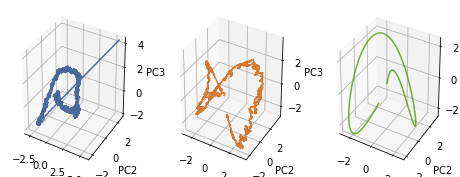

In [ ]:
# Plot activity in state space (projected separately on each datasets' PCs)

# 2D

fig = plt.figure(figsize=figsize)
axes =  fig.subplots(1, 3)

for i, R_i_proj in enumerate(R_projs):
    ax = axes[i]
    
    ax.plot(R_i_proj[:, 0], R_i_proj[:, 1], c=colors[i])
    # Init and final
    ax.plot(R_i_proj[0, 0], R_i_proj[0, 1], 'o', ms=7, c=colors[i], alpha=0.8, label="Init" if i == 0 else None)
    ax.plot(R_i_proj[-1, 0], R_i_proj[-1, 1], '*', ms=10, c=colors[i], alpha=0.8, label="Final" if i == 0 else None)

    ax.axhline(0, c='0.5', zorder=-1)
    if i == 0:
        ax.legend(loc=4)
        ax.set_ylabel("PC2")
    ax.set_xlabel("PC1")
    ax.set_title(lbls[i])
fig.suptitle("Projection on the PCs of each dataset separately", y=1.05)
plt.show(fig)
plt.close(fig)

# 3D

fig = plt.figure(figsize=figsize)
for i, R_i_proj in enumerate(R_projs):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.plot(R_i_proj[:, 0], R_i_proj[:, 1], R_i_proj[:, 2], c=colors[i], label=lbls[i], alpha=0.8)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

It turns out that this doesn't reveal so much. All trajectories have somewhat circular elements, the untrained one also has some initial transient (the straight line). But we projected on different axes for each plot, so there's not so much to compare. 

Let's project all the trajectories on only one set of PCs, e.g. the one of the trained network, and plot this:



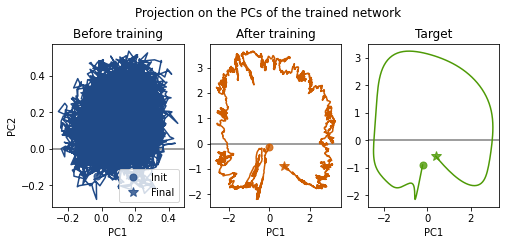

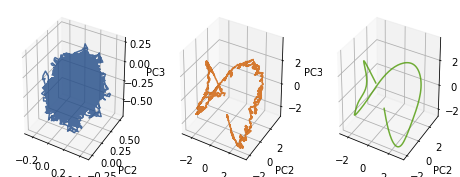

In [ ]:
# Plot activity in state space (projected on trained dataset's PCs)

# Project all one the axes computed for the trained networks. 
R_proj_ax1s = []
pca_proj = pcas[1]
for i, R_i in enumerate(Rs):
    R_i_proj = pca_proj.transform(R_i.T)
    R_proj_ax1s.append(R_i_proj)

# 2D

fig = plt.figure(figsize=figsize)
axes =  fig.subplots(1, 3)
for i, R_i_proj in enumerate(R_proj_ax1s):
    ax = axes[i]
    
    ax.plot(R_i_proj[:, 0], R_i_proj[:, 1], c=colors[i])
    # Init and final
    ax.plot(R_i_proj[0, 0], R_i_proj[0, 1], 'o', ms=7, c=colors[i], alpha=0.8, label="Init" if i == 0 else None)
    ax.plot(R_i_proj[-1, 0], R_i_proj[-1, 1], '*', ms=10, c=colors[i], alpha=0.8, label="Final" if i == 0 else None)

    ax.axhline(0, c='0.5', zorder=-1)
    if i == 0:
        ax.legend(loc=4)
        ax.set_ylabel("PC2")
    ax.set_xlabel("PC1")
    ax.set_title(lbls[i])
fig.suptitle("Projection on the PCs of the trained network", y=1.05)
plt.show(fig)
plt.close(fig)

# 3D

fig = plt.figure(figsize=figsize)
for i, R_i_proj in enumerate(R_proj_ax1s):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.plot(R_i_proj[:, 0], R_i_proj[:, 1], R_i_proj[:, 2], c=colors[i], label=lbls[i], alpha=0.8)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

This gives some more insight. First, the initial activity, despite being of similar magnitude, has only a small and very unstructured projection on the PCs of the trained network. But the trained network and the target evolve in a very similar manner -- the projection of the target is about the same size as when projected on its own PCs. (One could also quantify this by computing the projection of two sets of eigenvectors).

**c)** Can you compute, and plot, how many principal components of 
the RNN capture 90% of the total variance of the activity? This 
should be a graph plotting percent variance, between 0 and 100, on the y-axis as a function of PC # on the x-axis. 


**SOLUTION:**

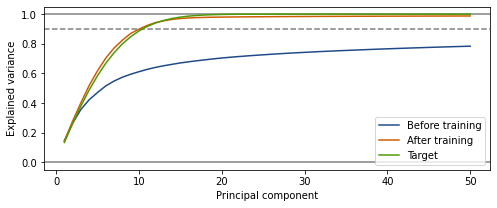

#pcs for 90% expl var:
  Before training:  50
  After training:  11
  Target:  11


In [ ]:
# Plot explained variance

fig = plt.figure(figsize=figsize)
ax = fig.subplots(1, 1)

# Name principle components
pcs = np.arange(n_comp) + 1

# cevr: cumsum_explainedvariance_ratio
for i, cevr in enumerate(cevrs):
    # Cumulative explained variance
    ax.plot(pcs, cevr, c=colors[i], label=lbls[i])
ax.legend(loc=4)
ax.axhline(0.9, ls='--', c='0.5', zorder=-1)
ax.axhline(0, c='0.5', zorder=-1)
ax.axhline(1, c='0.5', zorder=-1)
ax.set_xlabel("Principal component")
ax.set_ylabel("Explained variance")
plt.show(fig)
plt.close(fig)

# Where is 90% reached?
print("#pcs for 90% expl var:")
for i, cevr in enumerate(cevrs):
    idxs = list(cevr >= 0.9)
    pc_90 = pcs[ idxs.index(True) if True in idxs else len(idxs) - 1 ]
    # Or also possible:
    # pc_90 = pcs[np.argmax(cevr >= 0.9)] if cevr.max() >= 0.9 else np.NaN
    print("  %s: " % (lbls[i]), pc_90)

The plot shows that the trained network (as well as the target) has a substantially reduced dimensionality compared with the untrained network. 10 PCs cover 90% of the variance. 

## Connectivity inferred from the RNN


**a)** How has training changed the recurrent interactions? One way to quantify that is to look at the overall magnitude of the change, i.e., the norm of the difference between the untrained random matrix and the trained matrix inferred from the RNN fit to data. Compare this to the norm of the difference between any other two random matrices with  same size and variance as the untrained matrix. 

**SOLUTION:** The norm has increased dramatically, almost 7-fold. 



In [ ]:
# Compare norm difference between untrained and trained weights
norm_dJ = np.linalg.norm(J - J0)

# Compare with norm diff of two random matrices
J0_samps = J0.std() * np.random.randn(2, N, N)
norm_dJ0 = np.linalg.norm(J0_samps[1] - J0_samps[0]) 

print("Norms: ", norm_dJ, norm_dJ0, np.linalg.norm(J0))
print("Norm / sqrt(N): ", norm_dJ/np.sqrt(N), norm_dJ0/np.sqrt(N), np.linalg.norm(J0)/np.sqrt(N))
print("Relative difference, compared to random matrices: %.2f" % (norm_dJ / norm_dJ0))

Norms:  303.926381028162 47.47030293983699 33.57312599950607
Norm / sqrt(N):  13.592000962689452 2.122936485719672 1.5014358390412228
Relative difference, compared to random matrices: 6.40


**b)** Can you make a histogram of the entries in the trained recurrent matrix and compare it to the histogram of the elements in the untrained, randomly initialized recurrent matrix? The y-axis should be the log-frequency of the binned elements, and the x-axis should be the binned weight values. 

**c)**  Can you replot the same histograms as in (b) so the y-axes reflect logarithmic probbility density?

**SOLUTION:**

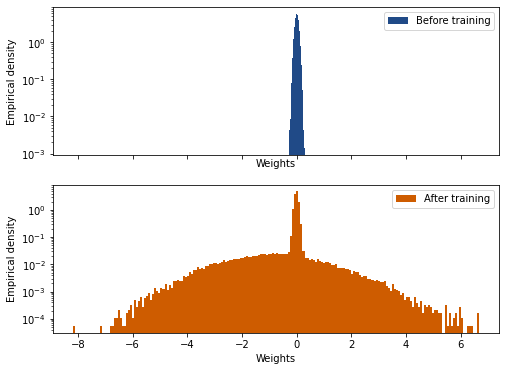

In [ ]:
# Histogram of entries
fig = plt.figure(figsize=(8, 6))
axes = fig.subplots(2, 1, sharex=True)
Js = [J0, J]

n_bins = 200

for i, J_i in enumerate(Js):
    ax = axes[i]
    ax.hist(J_i.flatten(), n_bins, density=True,
            color=colors[i], label=lbls[i], linewidth=0)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel("Weights")
    # ax.set_ylabel("Frequency")
    ax.set_ylabel("Empirical density")

plt.show(fig)
plt.close(fig)


The histograms reveal that the matrix changed dramatically: many weights are much larger in magnitude. However, the final distribution seems to be the sum of two distribution, where one is very similar to the distribution of untrained weights. 

To obtain a better idea what's going on there, it's worthwhile plotting the weight matrices themselves. 

Text(0.5, 1.05, 'After training')

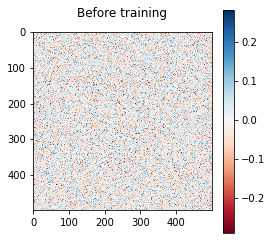

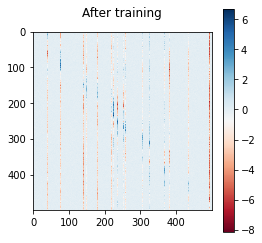

In [ ]:
# Plot matrices

# Before training
plt.matshow(J0, cmap='RdBu')
plt.colorbar()
plt.gca().xaxis.tick_bottom()
plt.title('Before training')
           
# After training
plt.matshow(J, cmap='RdBu')
plt.colorbar()
plt.gca().xaxis.tick_bottom()
plt.title('After training')

This looks strange! Only a small number of columns seem to be much larger than the rest. The reason is that actually only 50 units in the network were trained. For a deeper analysis of the network and its dynamics, it would probably make sense to separate these trained ones from the rest...

**d)** Have your code spit out the first 4 moments of the trained and random matrices, i.e., mean, variance, kurtosis, and skewness. Which of these modes has changed the most as a function of training to match the data, and what does it mean? 


In [ ]:
# First 4 moments of recurrent matrices
from scipy.stats import skew, kurtosis

print("Matrix Mean, Std, Skewness, Kurtosis")
for i, J_i in enumerate(Js):
    print("J_%s: " % i, (4 * "%.3f,  ") % (J_i.mean(), J_i.std(), skew(J_i.flatten()), kurtosis(J_i.flatten())))
    
print("Ratio: ", (4 * "%.3f,  ") % (J_i.mean() / J0.mean(), 
                                    J_i.std() / J0.std(), 
                                    skew(J_i.flatten()) / skew(J0.flatten()), 
                                    kurtosis(J_i.flatten()) / kurtosis(J0.flatten())))

Matrix Mean, Std, Skewness, Kurtosis
J_0:  0.000,  0.067,  -0.000,  0.015,  
J_1:  -0.080,  0.606,  -2.800,  25.560,  
Ratio:  -742.935,  9.022,  6466.707,  1735.426,  


The trained matrix is changed drastically on all moments. Relatively, the kurtosis changed most. But we saw that only a few columns changed, so maybe it's worthwhile selecting only these columns and look at their stats.

The columns in question can be separated out by checking the mean square of each column, and applying a cutoff (manually set after looking at the histogram). 

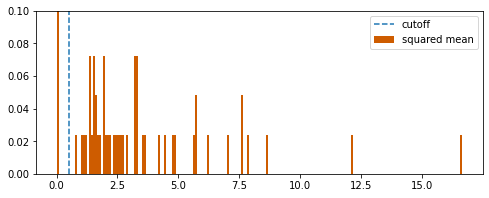

Number of neurons that were substantially changed:  50



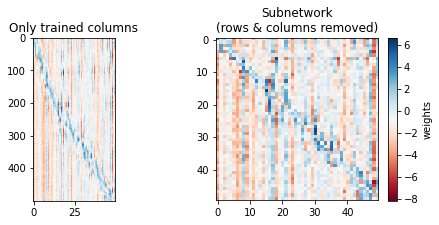

Matrix Mean, Std, Skewness, Kurtosis
J_0:  0.000,  0.067,  -0.000,  0.015,  
J_1:  -0.080,  0.606,  -2.800,  25.560,  
J_2:  -0.801,  1.747,  0.138,  0.306,  
Ratio:  -7444.138,  26.018,  -318.281,  20.794,  


In [ ]:
# Select changed columns. 
Jsqm = (J**2).mean(axis=0)
cutoff = 0.5

# Check histogram
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1, 1)
ax.hist(Jsqm, n_bins, density=True,
        color=colors[i], linewidth=0, label='squared mean')
ax.axvline(cutoff, ls='--', label='cutoff')
ax.legend()
ax.set_ylim(0, 0.1)
plt.show(fig)
plt.close(fig)

# Select only the columns above cutoff
mask = Jsqm > cutoff
Jt = J[:, mask]
print("Number of neurons that were substantially changed: ", mask.sum())
print("")

# Check histogram
fig = plt.figure(figsize=(8, 3))
axes = fig.subplots(1, 2)
# Show the columns
ax = axes[0]
im = ax.imshow(J[:, mask], aspect=0.2, cmap='RdBu', vmin=J.min(), vmax=J.max())
# plt.colorbar(im, ax=ax, label="weights")
ax.set_title("Only trained columns")
# Reduce also the rows
ax = axes[1]
im = ax.imshow(J[mask][:, mask], aspect=1., cmap='RdBu', vmin=J.min(), vmax=J.max())
plt.colorbar(im, ax=ax, label="weights")
ax.set_title("Subnetwork\n(rows & columns removed)")
plt.show(fig)
plt.close(fig)

# Join all matrices to compare the stats
Js = [J0,  J, Jt]
# First 4 moments of recurrent matrices
from scipy.stats import skew, kurtosis

print("Matrix Mean, Std, Skewness, Kurtosis")
for i, J_i in enumerate(Js):
    print("J_%s: " % i, (4 * "%.3f,  ") % (J_i.mean(), J_i.std(), skew(J_i.flatten()), kurtosis(J_i.flatten())))
    
print("Ratio: ", (4 * "%.3f,  ") % (J_i.mean() / J0.mean(), 
                                    J_i.std() / J0.std(), 
                                    skew(J_i.flatten()) / skew(J0.flatten()), 
                                    kurtosis(J_i.flatten()) / kurtosis(J0.flatten())))

This reveals two things: first, the there are stronly positive entries along the diagonal, and negative ones further away from that. This is reminiscent of a ring attractor, for which the concept of a moving bump has been extensively studied [Thoery: Ben-Yishai, Bar-Or, Sompolinsky, 1995; fruit fly: Kim, Rouault, Druckmann, Jayaraman, 2017]. 

Also, the moment look quite different now, with a much more pronounced negative mean. 

**e)** Now that you have some intuition for the spectral modes of interaction matrices, as in Problem 1 **e**, can you plot the eigenvalues of the trained matrix? How has the distribution changed relative to where it started, i.e., that of the eigenvalue spectrum of the randomly initialized matrix? What do you think the implications of this change are, at the level of the dynamics? 


**SOLUTION:**

---



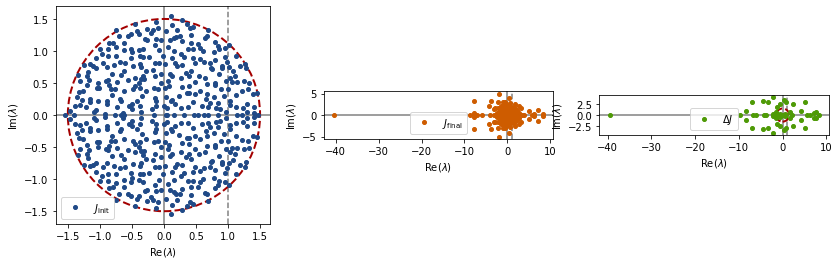

In [ ]:
# Plot eigenvalue spectrum
fig = plt.figure(figsize=(14, 4))
axes = fig.subplots(1, 3)
Js = [J0, J, J-J0]
lbls_J = ["$J_\mathrm{init}$", "$J_\mathrm{final}$", "$\Delta J$"]

for i, J_i in enumerate(Js):
    ax = axes[i]
    ew = np.linalg.eigvals(J_i)
    ax.plot(ew.real, ew.imag, 'o', ms=4, c=colors[i], label=lbls_J[i])

    circ = plt.Circle((0, 0), radius=g, edgecolor=colors[3], lw=2, facecolor='None', linestyle='dashed')
    ax.add_patch(circ)
    
    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable='box')
    
    ax.legend()
    ax.axhline(0, c='0.5', zorder=-1)
    ax.axvline(0, c='0.5', zorder=-1)
    ax.axvline(1, ls='--', c='0.5', zorder=-1)
    ax.set_xlabel("$\mathrm{Re}(\lambda)$")
    ax.set_ylabel("$\mathrm{Im}(\lambda)$")

plt.show(fig)
plt.close(fig)

The eigenvalues are drastically increased, and the distribution is less uniform. The latter points to dynamics that unfold in a lower-dimensional space, in agreement with the picture we obtained from PCA. 